In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import RidgeCV, LassoCV, LogisticRegression, HuberRegressor
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor,
                              ExtraTreesRegressor, StackingRegressor)

from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (brier_score_loss, accuracy_score,
                             log_loss, mean_squared_error, 
                             mean_absolute_error)
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV

from utils import get_season_pace, get_season_eff, GameElo, elo_predict, get_season_four_factors, NCAAElo

In [2]:
# the folders containing data files
data_folder = './kaggle_data/'
pom_folder = './kaggle_data/ken_pom_stats/'

In [3]:
mens_sp = pd.read_csv(f'{data_folder}MTeamSpellings.csv', encoding='latin-1')
mens_teams = pd.read_csv(f'{data_folder}MTeams.csv')
mens_reg = pd.read_csv(f'{data_folder}MRegularSeasonCompactResults.csv')
mens_det = pd.read_csv(f'{data_folder}MRegularSeasonDetailedResults.csv')
mens_seeds = pd.read_csv(f'{data_folder}MNCAATourneySeeds.csv')
tourney_df = pd.read_csv(f'{data_folder}MNCAATourneyCompactResults.csv')
sec_tourn_df = pd.read_csv(f'{data_folder}MSecondaryTourneyCompactResults.csv')
pretourney_odds = pd.read_csv(f'{data_folder}ncaa_mens_odds.csv')
this_yr_odds = pd.read_csv(f'{data_folder}this_yr_pretourney.csv')

tourney_teams = list(set(pd.concat([tourney_df['WTeamID'], tourney_df['LTeamID']])))
mens_team_dict = mens_teams.set_index('TeamID')['TeamName'].to_dict()

In [4]:
# computing ELO for every game from 1985 until the present. 
# this requires stacking and sorting all of the men's games

elo_columns = ['Season', 'DayNum', 'WTeamID', 'LTeamID', 'WLoc']

elo_games = (
    pd.concat([mens_reg[elo_columns], tourney_df[elo_columns], sec_tourn_df[elo_columns]])
    .sort_values(by=['Season', 'DayNum'], ascending=True)
    .reset_index(drop=True)
)

# instantiating the ELO class
all_games_elo = NCAAElo(elo_games).process_elo()

elo_games['winner_elo_prob'] = all_games_elo.winner_probs
elo_games['winner_elo'] = all_games_elo.winner_elo
elo_games['loser_elo'] = all_games_elo.loser_elo

In [5]:
# the difficulty is that we need the ELO *after* the last game of the season to
# use as the ELO throughout the NCAA tournament. it's possible to do conditional
# updates, but i haven't implemented it - cost/benefit seems low right now.
# in any case, i use shift(-1) to get the nxt and create a dictionary with
# that value for each team

winners = (
    elo_games[['Season', 'DayNum', 'WTeamID', 'winner_elo']]
    .rename(columns={'WTeamID' : 'teamid', 'winner_elo' : 'team_elo'})
)

losers = (
    elo_games[['Season', 'DayNum', 'LTeamID', 'loser_elo']]
    .rename(columns={'LTeamID' : 'teamid', 'loser_elo' : 'team_elo'})
)

total_elo = (
    pd.concat([winners, losers])
    .sort_values(by=['Season', 'DayNum'])
)

total_elo['next_elo'] = total_elo.groupby('teamid')['team_elo'].transform(lambda x: x.shift(-1))

team_elo_dict = total_elo.set_index(['Season', 'DayNum', 'teamid'])['next_elo'].to_dict()

In [6]:
# simple template for grabbing game by game *next game* elos
win_ratings = []
lose_ratings = []

for s, dn, w, l in zip(mens_reg.Season, mens_reg.DayNum, mens_reg.WTeamID, mens_reg.LTeamID):
    win_rating_ = team_elo_dict[(s, dn, w)]
    lose_rating_ = team_elo_dict[(s, dn, l)]
    
    win_ratings.append(win_rating_)
    lose_ratings.append(lose_rating_)


    
mens_reg['winner_elo_post_game'] = win_ratings
mens_reg['loser_elo_post_game'] = lose_ratings

In [7]:
# separating the winners and losers again in order to concat them
# with compatible column names

mens_reg_winners = (
    mens_reg
    .groupby(['Season', 'WTeamID'])[['DayNum', 'winner_elo_post_game']]
    .last()
    .reset_index()
    .rename(columns={'WTeamID' : 'teamid', 'winner_elo_post_game' : 'elo_post_game'})
)

mens_reg_losers = (
    mens_reg
    .groupby(['Season', 'LTeamID'])[['DayNum', 'loser_elo_post_game']]
    .last()
    .reset_index()
    .rename(columns={'LTeamID' : 'teamid', 'loser_elo_post_game' : 'elo_post_game'})
)

In [8]:
# getting the final ELO rating for each Season-Team in the dataset and
# putting those ratings into a dictionary for easy access 

season_end_elo = (
    pd.concat([mens_reg_winners, mens_reg_losers])
    .sort_values(by=['Season', 'teamid', 'DayNum'])
)

season_end_elo_dict = (
    season_end_elo
    .groupby(['Season', 'teamid'])['elo_post_game']
    .last()
    .to_dict()
)

In [9]:
# creating an alternate spelling dict and adding seeded teams
mens_sp_dict = mens_sp.set_index('TeamNameSpelling')['TeamID'].to_dict()

mens_sp_dict['ut rio grande valley'] = 1410
mens_sp_dict['liu'] = 1254
mens_sp_dict['illinois chicago'] = 1227
mens_sp_dict['texas a&m corpus chris'] = 1394
mens_sp_dict['louisiana lafayette'] = 1418
mens_sp_dict['southeast missouri st.'] = 1369
mens_sp_dict['southwest missouri st.'] = 1283
mens_sp_dict['cal st. bakersfield'] = 1167
mens_sp_dict['tennessee martin'] = 1404
mens_sp_dict['louisiana monroe'] = 1419
mens_sp_dict['arkansas little rock'] = 1114
mens_sp_dict['st. francis ny'] = 1383
mens_sp_dict['st. francis pa'] = 1384
mens_sp_dict['mississippi valley st.'] = 1290
mens_sp_dict['arkansas pine bluff'] = 1115

In [10]:
mens_season_ff = get_season_four_factors(df=mens_det)

In [11]:
mens_det['WPoss'] = mens_det['WFGA'] - mens_det['WOR'] + mens_det['WTO'] + (0.475 * mens_det['WFTA'])
mens_det['LPoss'] = mens_det['LFGA'] - mens_det['LOR'] + mens_det['LTO'] + (0.475 * mens_det['LFTA'])
mens_det['WPer100'] = (mens_det['WScore'] / mens_det['WPoss']) * 100
mens_det['LPer100'] = (mens_det['LScore'] / mens_det['LPoss']) * 100

In [12]:
# since i'm computing offensive/defensive efficiency per 100 possesions
# i do not need to exclude overtime games. if i were predicting 
# logodds, or pure team strength, i would. i tried raddar's solution
# hence the mention, but since he included HCA i thought there has
# to be a better way!

# mens_det = mens_det.query("NumOT < 1").copy()

In [13]:
mens_season_eff_dict = {}

for s in mens_det.Season.unique():
    df_ = get_season_eff(season=s, df=mens_det, teams_dict=mens_team_dict)
    mens_season_eff_dict[s] = df_

In [14]:
mens_season_pace_dict = {}

for s in mens_det.Season.unique():
    df_ = get_season_pace(season=s, df=mens_det)
    mens_season_pace_dict[s] = df_

In [15]:
# reformatting the pretourney odds from sportsoddshistory.com so the
# implied probabilities can be added to the relevant dataframes

pretourney_odds['small_team'] = pretourney_odds.team.str.lower()
pretourney_odds['small_team'] = pretourney_odds['small_team'].str.strip()
pretourney_odds['teamid'] = [mens_sp_dict[x] if x in mens_sp_dict else -99 for x in pretourney_odds.small_team]
pretourney_odds['season'] = pretourney_odds['season'] + 1

pretourney_odds['implied_probability'] = (
    np.where(
        ((pretourney_odds['season'] < 2022) & (pretourney_odds['odds_int'] == 0)),
         0.0025,
         pretourney_odds['implied_probability']
    )
)           

pretourney_odds = pretourney_odds[['teamid', 'season', 'implied_probability']].copy()

In [16]:
# doing the same as above to this year's probabilities 

this_yr_odds['small_team'] = this_yr_odds.team.str.lower()
this_yr_odds['small_team'] = this_yr_odds['small_team'].str.strip()
this_yr_odds['teamid'] = [mens_sp_dict[x] if x in mens_sp_dict else -99 for x in this_yr_odds.small_team]
this_yr_odds['season'] = this_yr_odds['season'] + 1
       
# note i did not fill in nans with a negligible value because there aren't any
# the NaNs appear later on and are filled in there (mens_submission)
this_yr_odds = this_yr_odds[['teamid', 'season', 'implied_probability']].copy()

In [17]:
# kpom's summary statistics for each season (2003-2023)

pomdf = pd.DataFrame()

for file in os.listdir(f'{pom_folder}'):
    
    if 'roster' not in file:
        df_ = pd.read_csv(f'{pom_folder}{file}')
        pomdf = pd.concat([pomdf, df_], axis=0)

pomdf.reset_index(inplace=True, drop=True)
pomdf.columns = pomdf.columns.str.lower()
pomdf['teamname'] = pomdf['teamname'].str.lower().str.strip()
pomdf['teamid'] = pomdf['teamname'].map(mens_sp_dict)

pomdf = pomdf[pomdf['teamid'].isin(tourney_teams)].copy()

print('null teamid where seed >16:', pomdf[pomdf['seed'] >= 16]['teamid'].isnull().sum())

null teamid where seed >16: 0


In [18]:
# adding my estimates of pace, oeff, and deff (ridge regression on each season)
# to the pomdf dataframe 

my_paces = []

for x, y in zip(pomdf.season, pomdf.teamid):
    
    try:
        value = mens_season_pace_dict[x].loc[y]['pace']
        my_paces.append(value)
    except:
        my_paces.append(-99)
        
my_off_eff = []

for x, y in zip(pomdf.season, pomdf.teamid):
    
    try:
        value_ = mens_season_eff_dict[x].loc[y]['coef']
        my_off_eff.append(value_)
    except:
        my_off_eff.append(-99)
        
my_def_eff = []

for x, y in zip(pomdf.season, pomdf.teamid):
    
    try:
        value_ = mens_season_eff_dict[x].loc[y]['coef_def']
        my_def_eff.append(value_)
    except:
        my_def_eff.append(-99)

In [19]:
pomdf['my_pace'] = np.array(my_paces).round(1)
pomdf['my_off'] = np.array(my_off_eff)
pomdf['my_def'] = np.array(my_def_eff)
pomdf['my_total'] = pomdf['my_off'] + (-1 * pomdf['my_def'])

In [20]:
team_filter = (mens_det['WTeamID'].isin(tourney_teams)) & (mens_det['LTeamID'].isin(tourney_teams))

mens_det = mens_det[team_filter].copy()

In [21]:
# reorganizing tourney data

team_pairs = tourney_df[['WTeamID', 'LTeamID']].values
idx = np.random.randint(0, team_pairs.shape[1], team_pairs.shape[0])

tourney_df['team_one'] = [x[0] for x in np.take_along_axis(team_pairs, idx[:, None], 1)]
tourney_df['team_two'] = (
    np.where(tourney_df['team_one'] == tourney_df['WTeamID'],
             tourney_df['LTeamID'],
             tourney_df['WTeamID']
            )
)

tourney_df['team_one_score'] = (
    np.where(tourney_df['team_one'] == tourney_df['WTeamID'],
             tourney_df['WScore'],
             tourney_df['LScore']
            )
)

tourney_df['team_two_score'] = (
    np.where(tourney_df['team_two'] == tourney_df['WTeamID'],
             tourney_df['WScore'],
             tourney_df['LScore']
            )
)


tourney_df['score_diff'] = tourney_df['team_one_score'].sub(tourney_df['team_two_score'])
tourney_df['team_one_win'] = (
    np.where(tourney_df['team_one_score'] > tourney_df['team_two_score'],
             1,
             0)
)

tourney_df = (
    tourney_df
    .merge(pomdf,
           how='left',
           left_on=['Season', 'team_one'],
           right_on=['season', 'teamid'],)
    .drop(columns=['teamid'])
)

tourney_df.columns = ['team_one_' + x if x in pomdf.columns else x for x in tourney_df.columns]


m_tourney_df = (
    tourney_df
    .merge(pomdf,
           how='left',
           left_on=['Season', 'team_two'],
           right_on=['season', 'teamid'])
    .drop(columns=['teamid'])
)

m_tourney_df.columns = ['team_two_' + x if x in pomdf.columns else x for x in m_tourney_df.columns]

m_tourney_df['team_one_win'] = (
    np.where(m_tourney_df['team_one_score'] > m_tourney_df['team_two_score'],
             1,
             0)
)

In [22]:
# selecting a column w/efficiency stats to use to drop the others
m_tourney_df.dropna(subset=['team_two_my_off'], inplace=True)

In [23]:
m_tourney_df = (
    m_tourney_df
    .merge(pretourney_odds,
           how='left',
           left_on=['Season', 'team_one'],
           right_on=['season', 'teamid'])
    .drop(columns=['season', 'teamid'])
    .rename(columns={'implied_probability' : 'team_one_implied_proba'})
)

In [24]:
m_tourney_df = (
    m_tourney_df
    .merge(pretourney_odds,
           how='left',
           left_on=['Season', 'team_two'],
           right_on=['season', 'teamid'])
    .drop(columns=['season', 'teamid'])
    .rename(columns={'implied_probability' : 'team_two_implied_proba'})
)

In [25]:
t1_ratings = []
t2_ratings = []
grand_elo_pred = []

for s, t1, t2 in zip(m_tourney_df['Season'], m_tourney_df['team_one'], m_tourney_df['team_two']):
    t1_elo = season_end_elo_dict[(s, t1)]
    t2_elo = season_end_elo_dict[(s, t2)]
    
    elo_pred_ = elo_predict(t1_elo, t2_elo)
    
    t1_ratings.append(t1_elo)
    t2_ratings.append(t2_elo)
    grand_elo_pred.append(elo_pred_)
    
m_tourney_df['t1_grand_elo'] = t1_ratings
m_tourney_df['t2_grand_elo'] = t2_ratings
m_tourney_df['grand_elo_pred'] = grand_elo_pred

In [26]:
m_tourney_df[['team_one_implied_proba', 'team_two_implied_proba']] =(
    m_tourney_df[['team_one_implied_proba', 'team_two_implied_proba']].fillna(0.0025)
)

In [27]:
linear_model = ['team_one_adjem','team_one_rankadjem', 'team_two_adjem', 
              'team_two_rankadjem', 'team_one_my_total', 'team_two_my_total',
               'team_one_seed', 'team_two_seed', 'grand_elo_pred']

In [28]:
reg_target = 'score_diff'

ridge_model = RidgeCV(alphas=[100, 500, 700], cv=10)
lasso_model = LassoCV(alphas=[0.1, 0.2, 0.5, 1], cv=10)
gbm_model = GradientBoostingRegressor(loss='absolute_error')
                              
X = m_tourney_df[linear_model]
y = m_tourney_df[reg_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


gbm_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)


print('lasso MAE:', mean_absolute_error(y_test, lasso_model.predict(X_test)))
print('ridge MAE:', mean_absolute_error(y_test, ridge_model.predict(X_test)))
print('gbm MAE:', mean_absolute_error(y_test, gbm_model.predict(X_test)))

lasso MAE: 8.595897682747294
ridge MAE: 8.602931530141536
gbm MAE: 8.701022118166803


<Axes: ylabel='score_diff'>

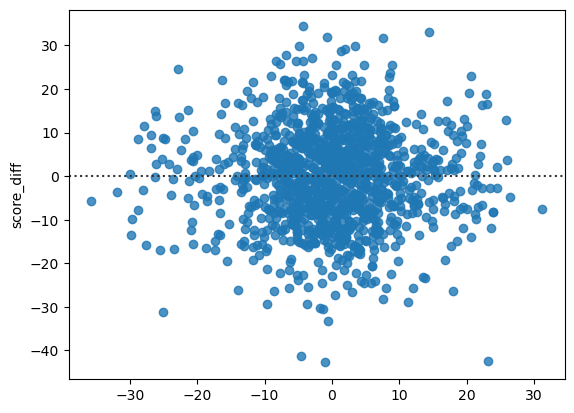

In [29]:
sns.residplot(x=ridge_model.predict(X), y=y)

In [30]:
ridge_model.fit(X, y)

RidgeCV(alphas=[100, 500, 700], cv=10)

In [31]:
model_cols = ['team_one_rankadjtempo','team_one_adjoe',
              'team_one_implied_proba', 'team_two_adjoe','team_two_adjde',
              'team_two_implied_proba', 'pred_diff', 'grand_elo_pred']

target = 'team_one_win'

In [32]:
# identifying rank columns and converting them to categories
# the goal was to take advantage of native cat handling
rank_cols = [x for x in tourney_df.columns if 'rank' in x]
m_tourney_df[rank_cols] = m_tourney_df[rank_cols].astype('category')

# predicting the game spread to use as an input to the win probability
# model
m_tourney_df['pred_diff'] = ridge_model.predict(m_tourney_df[linear_model])
model_cols.extend(['pred_diff'])

In [54]:
gbm_cl_model = GradientBoostingClassifier(random_state=35,
                                          max_depth=3,
                                          n_estimators=45,
                                          min_samples_leaf=40,
                                          n_iter_no_change=5)

X = m_tourney_df[model_cols].copy()
y = m_tourney_df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=94)

gbm_cl_model.fit(X_train, y_train)

params = {
    'max_depth' : [2, 3],
    'n_estimators' : [40, 45],
    'min_samples_leaf' : [25, 28, 31, 40, 50]
}

gridsearch_model = GridSearchCV(estimator=gbm_cl_model, cv=15, param_grid=params, scoring='neg_log_loss')
gridsearch_model.fit(X, y)

print("gbm log loss:", log_loss(y_test, gbm_cl_model.predict_proba(X_test)[:,1]))
print("gridsearch loss:", gridsearch_model.best_score_)

gbm log loss: 0.5328522523551723
gridsearch loss: -0.5481717049874278


In [55]:
# creating a calibrated classifier
cal_model = CalibratedClassifierCV(estimator=gbm_cl_model, cv=12)
cal_model.fit(X_train, y_train)

print("calibrated log loss:", log_loss(y_test, cal_model.predict_proba(X_test)[:,1]))
print("calibrated brier loss:", brier_score_loss(y_test, cal_model.predict_proba(X_test).round(3)[:,1]))

calibrated log loss: 0.532019247902066
calibrated brier loss: 0.17819154183266933


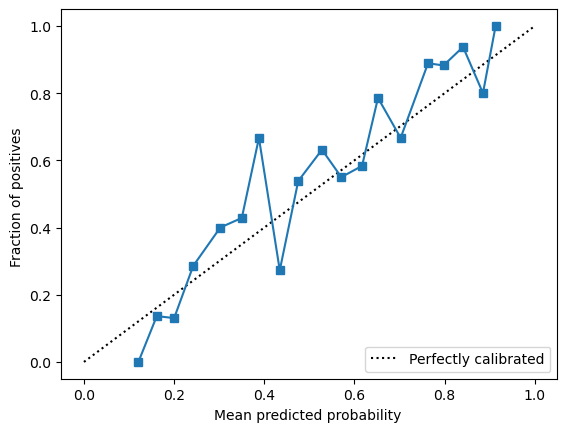

In [56]:
y_probs = cal_model.predict_proba(X_test).round(3)[:,1]

prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=22)

disp = CalibrationDisplay(prob_true, prob_pred, y_probs)

disp.plot()

In [57]:
# fitting the chosen model on the entire dataset 

cal_model.fit(X, y)

CalibratedClassifierCV(cv=12,
                       estimator=GradientBoostingClassifier(min_samples_leaf=40,
                                                            n_estimators=45,
                                                            n_iter_no_change=5,
                                                            random_state=35))

In [58]:
X_test['preds'] = cal_model.predict_proba(X_test).round(3)[:,1]
X_test['result'] = y_test

In [38]:
# from sklearn.inspection import permutation_importance

# pi = permutation_importance(gbm_cl_model, X_test[model_cols], y_test, scoring=['neg_log_loss', 'neg_brier_score'], n_repeats=8)

# useful_features = []

# for f, i in zip(model_cols, pi['neg_log_loss']['importances_mean']):
#     if i.round(3) >= 0.001:
#         useful_features.append(f)
#     print(f, i.round(3))

In [60]:
mens_submission = pd.read_csv(f'{data_folder}SampleSubmission2023.csv')

mens_submission['team_one'] = [int(x[5:9]) for x in mens_submission.ID]
mens_submission['team_two'] = [int(x[10:15]) for x in mens_submission.ID]
mens_submission['season'] = 2023

# creating a dict of this year's seeds
mens_seeds = mens_seeds.query("Season == 2023").copy()

mens_seeds_dict = mens_seeds.set_index('TeamID')['Seed'].to_dict()

# limiting the pool to this year's teams
condition = ((mens_submission['team_one'].isin(mens_seeds_dict.keys())) & 
             (mens_submission['team_two'].isin(mens_seeds_dict.keys()))
            )

mens_submission = mens_submission[condition].copy()

# getting Elo predictions

grand_elo_sub_preds = []

for t1, t2 in zip(mens_submission['team_one'], mens_submission['team_two']):

        proba_ = elo_predict(season_end_elo_dict[(2023, t1)], season_end_elo_dict[(2023, t2)])
        grand_elo_sub_preds.append(proba_)
        
mens_submission['grand_elo_pred'] = grand_elo_sub_preds

# getting seeds

mens_submission['team_one_seed'] = [mens_seeds_dict[team] for team in mens_submission['team_one']]
mens_submission['team_two_seed'] = [mens_seeds_dict[team] for team in mens_submission['team_two']]

In [61]:
# creating a dictionary of teamid -> implied probs. note that if a team does not appear
# i assign a negligible probability. teams without vegas odds won't be contenders

thisyr_oddsdict = this_yr_odds.set_index('teamid')['implied_probability'].to_dict()

mens_submission['team_one_implied_proba'] = (
    [thisyr_oddsdict[x] if x in thisyr_oddsdict else 0.0025 for x in mens_submission['team_one']]
)

mens_submission['team_two_implied_proba'] = (
    [thisyr_oddsdict[x] if x in thisyr_oddsdict else 0.0025 for x in mens_submission['team_two']]
)

In [62]:
# lists of columns from ken pom's df and my own stats that were used
# to train the model

pom_cols = ['season', 'teamid', 'ranktempo', 'adjtempo', 'rankadjtempo', 'rankoe', 
            'adjoe', 'adjde', 'rankadjde', 'adjem', 'rankadjem', 'adjtempo',
            'rankadjtempo', 'rankadjoe']

my_cols = ['team_one_my_total', 'team_two_my_total']

In [63]:
# limiting the pom_cols to non-duplicates because i made an error earlier

pom_cols = list(set(pom_cols))
pom_model_df = pomdf[pom_cols].copy()

mens_submission = (
    mens_submission
    .merge(pom_model_df,
           how='left',
           left_on=['season', 'team_one'],
           right_on=['season', 'teamid'],)
    .drop(columns=['teamid'])
)

mens_submission.columns = ['team_one_' + x if x in pom_model_df.columns else x for x in mens_submission.columns]
mens_submission.rename(columns={'team_one_season' : 'season'}, inplace=True)

mens_submission = (
    mens_submission
    .merge(pom_model_df,
           how='left',
           left_on=['season', 'team_two'],
           right_on=['season', 'teamid'])
    .drop(columns=['teamid'])
)

mens_submission.columns = ['team_two_' + x if x in pom_model_df.columns else x for x in mens_submission.columns]
mens_submission.rename(columns={'team_two_season' : 'season'}, inplace=True)

In [64]:
my_season_stats = mens_season_eff_dict[2023].reset_index()
my_season_stats['my_total'] = my_season_stats['coef'] + (-1 * my_season_stats['coef_def'])
my_season_stats.drop(columns=['coef', 'coef_def'], inplace=True)

In [65]:
mens_submission = (
    mens_submission
    .merge(my_season_stats,
           how='left',
           left_on=['season', 'team_one'],
           right_on=['season', 'teamid'])
    .drop(columns=['teamid'])
)

mens_submission.columns = ['team_one_' + x if x in my_season_stats.columns else x for x in mens_submission.columns]
mens_submission.rename(columns={'team_one_season' : 'season'}, inplace=True)

mens_submission = (
    mens_submission
    .merge(my_season_stats,
           how='left',
           left_on=['season', 'team_two'],
           right_on=['season', 'teamid'])
    .drop(columns=['teamid'])
)

mens_submission.columns = ['team_two_' + x if x in my_season_stats.columns else x for x in mens_submission.columns]
mens_submission.rename(columns={'team_two_season' : 'season'}, inplace=True)

In [66]:
# filling in nan values using column quantiles. in the rank columns 
# i use 0.8, and in the numeric columns 0.2

ranked_cols = [x for x in mens_submission.columns if 'rank' in x]
not_ranked_cols = [x for x in mens_submission.columns if x not in ranked_cols]

quan_vals = mens_submission[ranked_cols].quantile(0.8)
non_ranked_quan_vals = mens_submission[not_ranked_cols].quantile(0.2)

mens_submission[ranked_cols] = mens_submission[ranked_cols].fillna(quan_vals)
mens_submission[not_ranked_cols] = mens_submission[not_ranked_cols].fillna(non_ranked_quan_vals)

C:\Users\yaobv\AppData\Local\Temp\ipykernel_2520\1700174904.py:8: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  non_ranked_quan_vals = mens_submission[not_ranked_cols].quantile(0.2)


In [130]:
mens_submission['pred_diff'] = ridge_model.predict(mens_submission[linear_model])
mens_submission['model_pred'] = cal_model.predict_proba(mens_submission[model_cols])[:,1]

mens_submission['Pred'] = mens_submission['model_pred']

<Axes: >

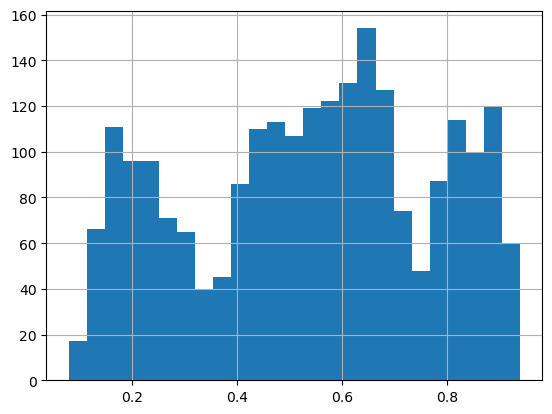

In [68]:
mens_submission['Pred'].hist(bins=25)

In [69]:
womens_teams = pd.read_csv(f'{data_folder}WTeams.csv')
womens_conf = pd.read_csv(f'{data_folder}WTeamConferences.csv')
womens_reg = pd.read_csv(f'{data_folder}WRegularSeasonCompactResults.csv')
womens_det = pd.read_csv(f'{data_folder}WRegularSeasonDetailedResults.csv')
womens_seeds = pd.read_csv(f'{data_folder}WNCAATourneySeeds.csv')
womens_tourn = pd.read_csv(f'{data_folder}WNCAATourneyCompactResults.csv')

# creating a dictionary of womens team ids to be used later
womens_tourn_teams = list(set(pd.concat([womens_tourn['WTeamID'], womens_tourn['LTeamID']])))
womens_team_dict = womens_teams.set_index('TeamID')['TeamName'].to_dict()

In [70]:
# computing ELO for every game from 1985 until the present. 
# this requires stacking and sorting all of the women's games

elo_columns = ['Season', 'DayNum', 'WTeamID', 'LTeamID', 'WLoc']

Welo_games = (
    pd.concat([womens_reg[elo_columns], womens_tourn[elo_columns]])
    .sort_values(by=['Season', 'DayNum'], ascending=True)
    .reset_index(drop=True)
)

# instantiating the ELO class
Wall_games_elo = NCAAElo(Welo_games).process_elo()

Welo_games['winner_elo_prob'] = Wall_games_elo.winner_probs
Welo_games['winner_elo'] = Wall_games_elo.winner_elo
Welo_games['loser_elo'] = Wall_games_elo.loser_elo

In [72]:
# the difficulty is that we need the ELO *after* the last game of the season to
# use as the ELO throughout the NCAA tournament. it's possible to do conditional
# updates, but i haven't implemented it - cost/benefit seems low right now.
# in any case, i use shift(-1) to get the nxt and create a dictionary with
# that value for each team

winners = (
    Welo_games[['Season', 'DayNum', 'WTeamID', 'winner_elo']]
    .rename(columns={'WTeamID' : 'teamid', 'winner_elo' : 'team_elo'})
)

losers = (
    Welo_games[['Season', 'DayNum', 'LTeamID', 'loser_elo']]
    .rename(columns={'LTeamID' : 'teamid', 'loser_elo' : 'team_elo'})
)

Wtotal_elo = (
    pd.concat([winners, losers])
    .sort_values(by=['Season', 'DayNum'])
)

Wtotal_elo['next_elo'] = Wtotal_elo.groupby('teamid')['team_elo'].transform(lambda x: x.shift(-1))

Wteam_elo_dict = Wtotal_elo.set_index(['Season', 'DayNum', 'teamid'])['next_elo'].to_dict()

In [73]:
# simple template for grabbing game by game *next game* elos
Wwin_ratings = []
Wlose_ratings = []

for s, dn, w, l in zip(womens_reg.Season, womens_reg.DayNum, womens_reg.WTeamID, womens_reg.LTeamID):
    win_rating_ = Wteam_elo_dict[(s, dn, w)]
    lose_rating_ = Wteam_elo_dict[(s, dn, l)]
    
    Wwin_ratings.append(win_rating_)
    Wlose_ratings.append(lose_rating_)

womens_reg['winner_elo_post_game'] = Wwin_ratings
womens_reg['loser_elo_post_game'] = Wlose_ratings

In [74]:
# separating the winners and losers again in order to concat them
# with compatible column names

womens_reg_winners = (
    womens_reg
    .groupby(['Season', 'WTeamID'])[['DayNum', 'winner_elo_post_game']]
    .last()
    .reset_index()
    .rename(columns={'WTeamID' : 'teamid', 'winner_elo_post_game' : 'elo_post_game'})
)

womens_reg_losers = (
    womens_reg
    .groupby(['Season', 'LTeamID'])[['DayNum', 'loser_elo_post_game']]
    .last()
    .reset_index()
    .rename(columns={'LTeamID' : 'teamid', 'loser_elo_post_game' : 'elo_post_game'})
)

In [75]:
# getting the final ELO rating for each Season-Team in the dataset and
# putting those ratings into a dictionary for easy access 

Wseason_end_elo = (
    pd.concat([womens_reg_winners, womens_reg_losers])
    .sort_values(by=['Season', 'teamid', 'DayNum'])
)

Wseason_end_elo_dict = (
    Wseason_end_elo
    .groupby(['Season', 'teamid'])['elo_post_game']
    .last()
    .to_dict()
)

In [76]:
womens_season_ff = get_season_four_factors(df=womens_det)

In [77]:
womens_det['WPoss'] = womens_det['WFGA'] - womens_det['WOR'] + womens_det['WTO'] + (0.475 * womens_det['WFTA'])
womens_det['LPoss'] = womens_det['LFGA'] - womens_det['LOR'] + womens_det['LTO'] + (0.475 * womens_det['LFTA'])
womens_det['WPer100'] = (womens_det['WScore'] / womens_det['WPoss']) * 100
womens_det['LPer100'] = (womens_det['LScore'] / womens_det['LPoss']) * 100

In [78]:
womens_team_filter = ((womens_det['WTeamID'].isin(womens_tourn_teams) & 
                       (womens_det['LTeamID'].isin(womens_tourn_teams)))
                     )

womens_det = womens_det[womens_team_filter].copy()

In [79]:
womens_reg_filter = (
    ((womens_reg['WTeamID'].isin(womens_tourn_teams)) & (womens_reg['LTeamID'].isin(womens_tourn_teams)))
)

womens_reg_filtered = womens_reg[womens_reg_filter].copy()
womens_reg_filtered.reset_index(inplace=True, drop=True)

In [80]:
womens_season_eff_dict = {}

for s in womens_det.Season.unique():
    df_ = get_season_eff(season=s, df=womens_det, teams_dict=womens_team_dict)
    df_['off_eff_rank'] = df_['coef'].rank(ascending=False)
    df_['def_eff_rank'] = df_['coef_def'].rank(ascending=False)
    df_['my_total'] = df_['coef'] + (-1 * df_['coef_def'])
    womens_season_eff_dict[s] = df_

In [81]:
womens_season_pace_dict = {}

for s in womens_det.Season.unique():
    df_ = get_season_pace(season=s, df=womens_det)
    df_['pace_rank'] = df_['pace'].rank(ascending=False)
    womens_season_pace_dict[s] = df_

In [82]:
# reorganizing womens tourney data

team_pairs = womens_tourn[['WTeamID', 'LTeamID']].values
idx = np.random.randint(0, team_pairs.shape[1], team_pairs.shape[0])

womens_tourn['team_one'] = [x[0] for x in np.take_along_axis(team_pairs, idx[:, None], 1)]
womens_tourn['team_two'] = (
    np.where(womens_tourn['team_one'] == womens_tourn['WTeamID'],
             womens_tourn['LTeamID'],
             womens_tourn['WTeamID']
            )
)

womens_tourn['team_one_score'] = (
    np.where(womens_tourn['team_one'] == womens_tourn['WTeamID'],
             womens_tourn['WScore'],
             womens_tourn['LScore']
            )
)

womens_tourn['team_two_score'] = (
    np.where(womens_tourn['team_two'] == womens_tourn['WTeamID'],
             womens_tourn['WScore'],
             womens_tourn['LScore']
            )
)


womens_tourn['score_diff'] = womens_tourn['team_one_score'].sub(womens_tourn['team_two_score'])
womens_tourn['team_one_win'] = (
    np.where(womens_tourn['team_one_score'] > womens_tourn['team_two_score'],
             1,
             0)
)

In [83]:
t1_ratings = []
t2_ratings = []
grand_elo_pred = []

for s, t1, t2 in zip(womens_tourn['Season'], womens_tourn['team_one'], womens_tourn['team_two']):
    t1_elo = Wseason_end_elo_dict[(s, t1)]
    t2_elo = Wseason_end_elo_dict[(s, t2)]
    
    elo_pred_ = elo_predict(t1_elo, t2_elo)
    
    t1_ratings.append(t1_elo)
    t2_ratings.append(t2_elo)
    grand_elo_pred.append(elo_pred_)
    
womens_tourn['t1_grand_elo'] = t1_ratings
womens_tourn['t2_grand_elo'] = t2_ratings
womens_tourn['grand_elo_pred'] = grand_elo_pred

In [84]:
team_1_paces = []    
team_2_paces = []

team_1_totals = []
team_2_totals = []

for s, o, t in zip(womens_tourn['Season'], womens_tourn['team_one'], womens_tourn['team_two']):

    try:
        team_1_pace = womens_season_pace_dict[s].loc[o]['pace']    
        team_2_pace = womens_season_pace_dict[s].loc[t]['pace']           

        team_1_my_total = womens_season_eff_dict[s].loc[o]['my_total']
        team_2_my_total = womens_season_eff_dict[s].loc[t]['my_total']

        team_1_paces.append(team_1_pace)         
        team_2_paces.append(team_2_pace)

        team_1_totals.append(team_1_my_total)
        team_2_totals.append(team_2_my_total)

    except:
        team_1_paces.append(np.nan)            
        team_2_paces.append(np.nan)            
        team_1_totals.append(np.nan)
        team_2_totals.append(np.nan)

In [85]:
womens_tourn['team_one_pace'] = team_1_paces
womens_tourn['team_one_my_total'] = team_1_totals

womens_tourn['team_two_pace'] = team_2_paces
womens_tourn['team_two_my_total'] = team_2_totals

In [86]:
womens_tourn.dropna(subset=['team_one_my_total'], inplace=True)

In [87]:
w_linear_model = ['team_one_my_total', 'team_two_my_total', 'team_one_pace', 'team_two_pace',
                  'grand_elo_pred']

womens_diff_model = RidgeCV(alphas=[100, 500, 1000], cv=12)

X = womens_tourn[w_linear_model]
y = womens_tourn['score_diff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

womens_diff_model.fit(X_train, y_train)

print('alpha of model:', womens_diff_model.alpha_)
print('mae of womens diff model:', mean_absolute_error(y_test, womens_diff_model.predict(X_test)))

alpha of model: 1000
mae of womens diff model: 9.939701877194523


In [88]:
womens_diff_model.fit(X, y)

RidgeCV(alphas=[100, 500, 1000], cv=12)

In [89]:
womens_tourn['pred_diff'] = womens_diff_model.predict(womens_tourn[w_linear_model])

In [90]:
womens_model_cols = ['grand_elo_pred', 'team_one_pace', 
                     'team_one_my_total', 'team_two_pace', 
                     'team_two_my_total', 'pred_diff']

In [174]:
womens_gbm = GradientBoostingClassifier(n_iter_no_change=3, max_depth=2, n_estimators=50, min_samples_leaf=24)

w_params = {
    'n_estimators' : [50, 60, 70],
    'max_depth' : [2],
    'n_iter_no_change' : [5],
    'min_samples_leaf' : [22, 24, 26, 28]
}
gridsearch_model = GridSearchCV(estimator=womens_gbm, param_grid=w_params, cv=15, scoring='neg_log_loss')

womens_X = womens_tourn[womens_model_cols].copy()
womens_y = womens_tourn['team_one_win'].values

X_train, X_test, y_train, y_test = train_test_split(womens_X, womens_y, test_size=0.2, random_state=88)

womens_gbm.fit(X_train, y_train)
gridsearch_model.fit(womens_X, womens_y)

GridSearchCV(cv=15,
             estimator=GradientBoostingClassifier(max_depth=2,
                                                  min_samples_leaf=24,
                                                  n_estimators=50,
                                                  n_iter_no_change=3),
             param_grid={'max_depth': [2], 'min_samples_leaf': [22, 24, 26, 28],
                         'n_estimators': [50, 60, 70],
                         'n_iter_no_change': [5]},
             scoring='neg_log_loss')

In [173]:
gridsearch_model.best_score_

-0.42769749898982934

In [175]:
womens_calibrated = CalibratedClassifierCV(estimator=womens_gbm, cv=15)

womens_calibrated.fit(X_train, y_train)

print(brier_score_loss(y_test, womens_calibrated.predict_proba(X_test)[:,1]))

0.1373373650873165


In [176]:
# method chosen, fit on entire dataset
womens_gbm.fit(womens_X, womens_y)

womens_calibrated.fit(womens_X, womens_y)

CalibratedClassifierCV(cv=15,
                       estimator=GradientBoostingClassifier(max_depth=2,
                                                            min_samples_leaf=24,
                                                            n_estimators=50,
                                                            n_iter_no_change=3))

In [115]:
womens_submission = pd.read_csv(f'{data_folder}SampleSubmission2023.csv')
womens_seeds = pd.read_csv(f'{data_folder}WNCAATourneySeeds.csv')

# getting a list of this year's teams
womens_teams_thisyr = list(womens_seeds[womens_seeds['Season'] == 2023]['TeamID'].unique())

womens_submission['team_one'] = [int(x[5:9]) for x in womens_submission.ID]
womens_submission['team_two'] = [int(x[10:15]) for x in womens_submission.ID]
womens_submission['season'] = 2023

# limiting the pool to this year's teams
condition = ((womens_submission['team_one'].isin(womens_teams_thisyr)) & 
             (womens_submission['team_two'].isin(womens_teams_thisyr))
            )

womens_submission = womens_submission[condition].copy()

In [116]:
Wgrand_elo_preds = []

for t1, t2 in zip(womens_submission.team_one, womens_submission.team_two):
    
    t1_rating = Wseason_end_elo_dict[(2023, t1)]
    t2_rating = Wseason_end_elo_dict[(2023, t2)]
    
    elo_pred_ = elo_predict(t1_rating, t2_rating)
    Wgrand_elo_preds.append(elo_pred_)
    
womens_submission['grand_elo_pred'] = Wgrand_elo_preds

In [117]:
t1_pace = []
t2_pace = []
t1_eff = []
t2_eff = []



for t1, t2 in zip(womens_submission['team_one'], womens_submission['team_two']):
    
    try:
    
        t1_pace_ = womens_season_pace_dict[2023].loc[t1]['pace']
        t2_pace_ = womens_season_pace_dict[2023].loc[t2]['pace']
        t1_eff_ = womens_season_eff_dict[2023].loc[t1]['my_total']
        t2_eff_ = womens_season_eff_dict[2023].loc[t2]['my_total']

        t1_pace.append(t1_pace_)
        t2_pace.append(t2_pace_)
        t1_eff.append(t1_eff_)
        t2_eff.append(t2_eff_)
        
    except:
        
        t1_pace.append(55)
        t2_pace.append(55)
        t1_eff.append(-5)
        t2_eff.append(-5)

womens_submission['team_one_pace'] = t1_pace
womens_submission['team_two_pace'] = t2_pace
womens_submission['team_one_my_total'] = t1_eff
womens_submission['team_two_my_total'] = t2_eff

In [118]:
womens_submission['pred_diff'] = womens_diff_model.predict(womens_submission[w_linear_model])

In [177]:
womens_submission['model_pred'] = womens_gbm.predict_proba(womens_submission[womens_model_cols])[:,1]

In [178]:
womens_submission['Pred'] = womens_submission['model_pred']

In [179]:
womens_seeds_2023 = womens_seeds[womens_seeds['Season'] == 2023].copy()

Wone_seeds = womens_seeds_2023[womens_seeds['Seed'].str.contains('01')]['TeamID'].to_list()
Wsixteen_seeds = womens_seeds_2023[womens_seeds['Seed'].str.contains('16')]['TeamID'].to_list()

womens_submission['Pred'] = (
    np.where(womens_submission['team_one'].isin(Wsixteen_seeds),
             0,
             womens_submission['Pred'])
)

womens_submission['Pred'] = (
    np.where(womens_submission['team_two'].isin(Wsixteen_seeds),
             1,
             womens_submission['Pred'])
)

C:\Users\yaobv\AppData\Local\Temp\ipykernel_2520\3358348523.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Wone_seeds = womens_seeds_2023[womens_seeds['Seed'].str.contains('01')]['TeamID'].to_list()
C:\Users\yaobv\AppData\Local\Temp\ipykernel_2520\3358348523.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Wsixteen_seeds = womens_seeds_2023[womens_seeds['Seed'].str.contains('16')]['TeamID'].to_list()


<Axes: >

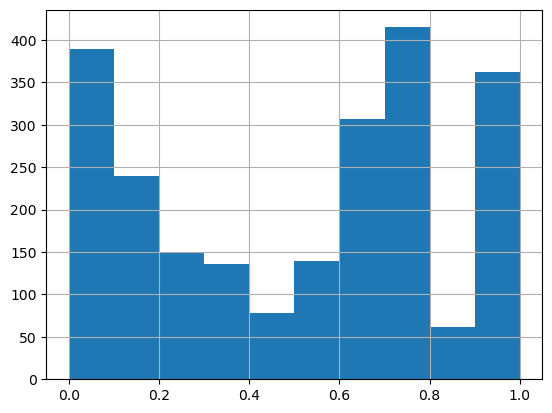

In [180]:
womens_submission['Pred'].hist()

In [181]:
# loading the sample to populate it 

full_submission = pd.read_csv(f'{data_folder}SampleSubmission2023.csv')

# limiting men's and women's submission df's
mens_submission_compact = mens_submission[['ID', 'Pred']].copy()
womens_submission_compact = womens_submission[['ID', 'Pred']].copy()

In [182]:
men_women_sub = pd.concat([mens_submission_compact, womens_submission_compact])

mwsubdict = men_women_sub.set_index('ID')['Pred'].to_dict()

full_submission['Pred'] = [mwsubdict[x] if x in mwsubdict else 0.5 for x in full_submission['ID']]

In [183]:
full_submission.to_csv('late_sub_03_28.csv', index=False)

array([[<Axes: title={'center': 'Pred'}>]], dtype=object)

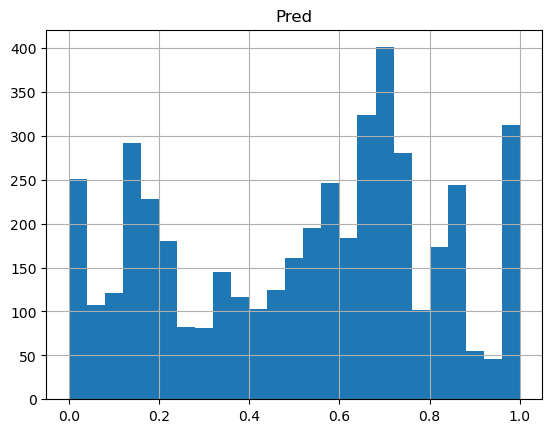

In [184]:
full_submission[full_submission['Pred'] != 0.5].hist(bins=25)

In [185]:
results_so_far = r"C:\Users\yaobv\Downloads\2023_03_26_20.18.36  scoring 116 games total.csv"

rsf_df = pd.read_csv(results_so_far)

so_far = rsf_df[rsf_df['Usage'] == 'Public'].copy()

In [186]:
full_dict = full_submission.set_index('ID')['Pred'].to_dict()

so_far['my_pred'] = [full_dict[id_] if id_ in full_dict else 0.5 for id_ in so_far.ID]

In [187]:
brier_score_loss(so_far['Pred'], so_far['my_pred'])

0.19608355431719157